In [11]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

%matplotlib notebook

from matplotlib import animation
from IPython.display import HTML

In [12]:
image_data = Image.open('aneurysm2d.png')
#image_data = Image.open('example.png')
image_data = image_data.convert("L")
image_data_arr = np.asarray(image_data, dtype=float)

<IPython.core.display.Javascript object>


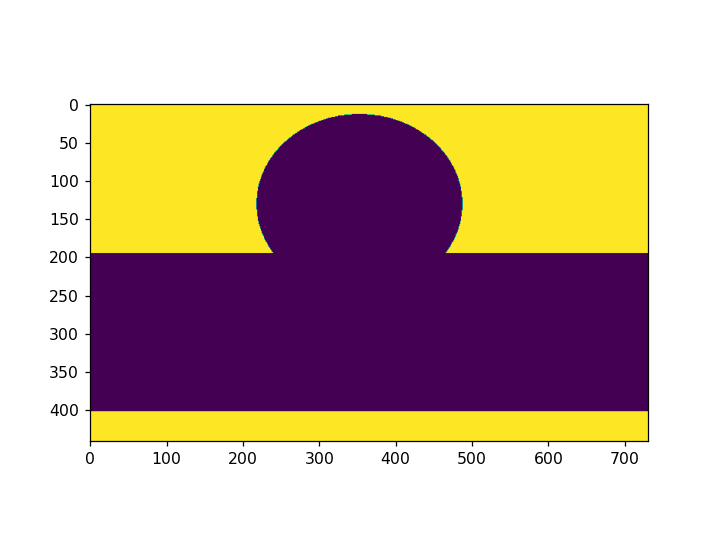

In [13]:
from skimage import filters
frangi = filters.frangi(image_data_arr, [2])
plt.imshow(frangi)

In [15]:
plt.imshow(image_data_arr)

<IPython.core.display.Javascript object>


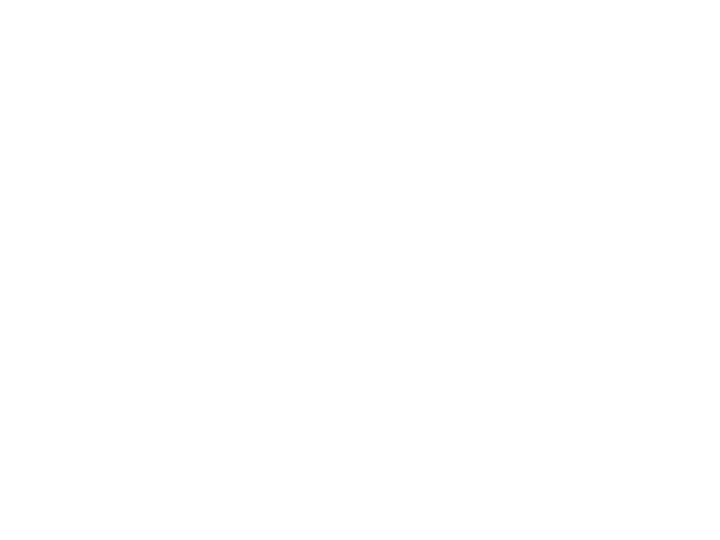

In [20]:
# Simulation parameters
Ny, Nx = image_data_arr.shape # x- and y- resolution
rho0                   = 700    # average density
tau                    = 0.6    # collision timescale
Nt                     = 100   # number of timesteps
plotRealTime = True # switch on for plotting as the simulation goes along
    
# Lattice speeds / weights
NL = 9
idxs = np.arange(NL)
cxs = np.array([0, 0, 1, 1, 1, 0,-1,-1,-1])
cys = np.array([0, 1, 1, 0,-1,-1,-1, 0, 1])
weights = np.array([4/9,1/9,1/36,1/9,1/36,1/9,1/36,1/9,1/36]) # sums to 1

# lattice mesh
X, Y = np.meshgrid(range(Nx), range(Ny))

# Initial Conditions
F = np.ones((Ny,Nx,NL)) #* rho0 / NL
np.random.seed(42)
F += 0.01*np.random.randn(Ny,Nx,NL)
F[:,:,3] += 2

rho = np.sum(F,2)

for i in idxs:
    F[:,:,i] *= rho0 / rho
    

X, Y = np.meshgrid(range(Nx), range(Ny))


# Cylinder boundary
cylinder = np.array(image_data_arr, dtype=bool)
    
# Prep figure
fig, ax = plt.subplots()
plt.close()

ims = []

# Simulation Main Loop
for it in range(Nt):
        
    # Drift
    for i, cx, cy in zip(idxs, cxs, cys):
        F[:,:,i] = np.roll(F[:,:,i], cx, axis=1)
        F[:,:,i] = np.roll(F[:,:,i], cy, axis=0)

    # Set reflective boundaries
    bndryF = F[cylinder,:]
    bndryF = bndryF[:,[0,5,6,7,8,1,2,3,4]]
    
    # Calculate fluid variables
    rho = np.sum(F,2)
    ux  = np.sum(F*cxs,2) / rho
    uy  = np.sum(F*cys,2) / rho
        
        
    # Apply Collision
    Feq = np.zeros(F.shape)
    for i, cx, cy, w in zip(idxs, cxs, cys, weights):
        Feq[:,:,i] = rho * w * ( 1 + 3*(cx*ux+cy*uy)  + 9*(cx*ux+cy*uy)**2/2 - 3*(ux**2+uy**2)/2 )
        
    F += -(1.0/tau) * (F - Feq)
        
    # Apply boundary 
    F[cylinder,:] = bndryF
    
    ux[cylinder] = np.nan
    uy[cylinder] = np.nan
        
    ax.invert_yaxis()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)    
    ax.set_aspect('equal')   
    
    cmap = plt.cm.get_cmap("jet").copy()
    cmap.set_bad('white')
        
    im = ax.imshow(ux**2 + uy**2, vmin=0, vmax=0.125, cmap='jet', animated=True)
    ims.append([im])
        
             
ani = animation.ArtistAnimation(fig, ims) 
HTML(ani.to_jshtml())
#ani.save('result_aneurysm_2d.gif', writer='PillowWriter')

0.0


In [5]:
ani.save('result_aneurysm_2d_new.gif', writer=animation.PillowWriter(fps=30) )